# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
use_col = ['volumn']
data = pd.read_csv('../../TrafficData/3-Copy1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
sequence_length = 720
pred_len = 360

<AxesSubplot: >

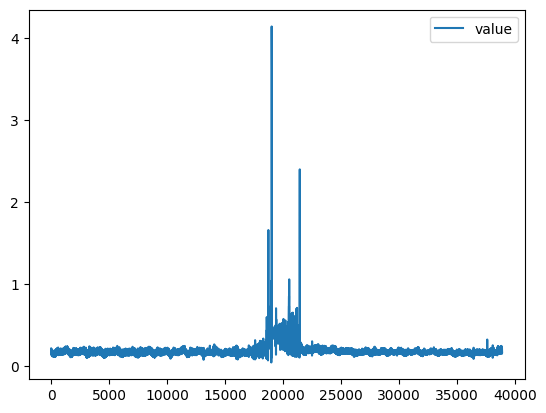

In [4]:
data.plot()

In [5]:
from torch import FloatTensor as FloatTensor

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [7]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [8]:
seed = 42

In [9]:
device = torch.device("cuda:0")

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360 # 1440
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [11]:
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [12]:
val_num = 1752

In [13]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_878930/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [14]:
train.tail(11)

,value
36949,0.160632
36950,0.185336
36951,0.190472
36952,0.180064
36953,0.202440
36954,0.148320
36955,0.175776
36956,0.168144
36957,0.166224
36958,0.169184


In [15]:
y_train.size()

torch.Size([35881, 360])

In [16]:
y_train[-1,-10:]

tensor([0.1853, 0.1905, 0.1801, 0.2024, 0.1483, 0.1758, 0.1681, 0.1662, 0.1692,
        0.1689], device='cuda:0')

In [17]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [18]:
x_train.size()

torch.Size([35881, 720])

In [19]:
x_val.size()

torch.Size([673, 720])

In [20]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [22]:
import copy

In [23]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
Epoch [41]/[100] running accumulative loss across all batches: 0.443
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [24]:
output = outputs
label = labels

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

0.0001198769

In [27]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

0.0001198769

### validation set에 대해서 attribution 구하기

In [28]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [29]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [30]:
print(temp.size()) # sum하기전에 형태

torch.Size([720])


In [31]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

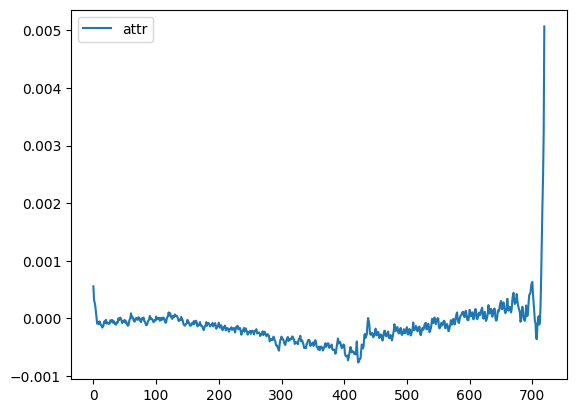

In [32]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

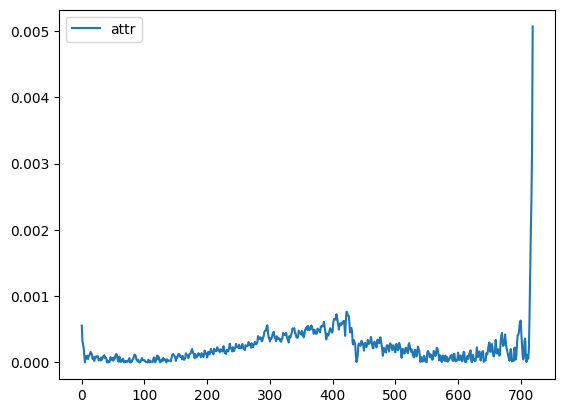

In [33]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [34]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
0,0.000557
1,0.000321
2,0.000278
3,0.000218
4,0.000108
...,...
709,0.000007
710,0.000039
711,0.000107
712,0.000058


In [35]:
outlier_max

attr    0.000693
dtype: float64

In [36]:
outlier_min

attr   -0.000299
dtype: float64

<AxesSubplot: >

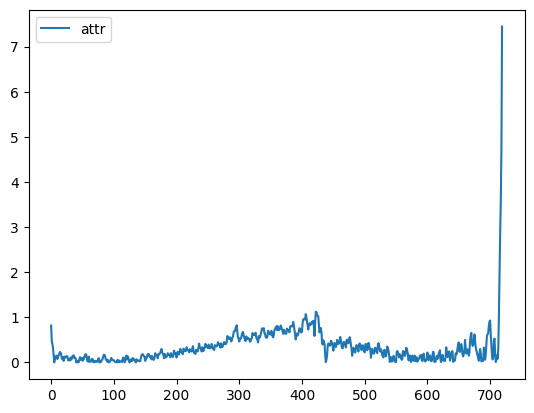

In [37]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [38]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.336409
std,0.434160
min,0.000000
25%,0.106669
50%,0.246247
75%,0.471049
max,7.445563


## 0과 1사이의 분포 확인하기

In [39]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
0,0.817656
1,0.471741
2,0.407601
3,0.319791
4,0.158429
...,...
709,0.009648
710,0.057290
711,0.157232
712,0.085264


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

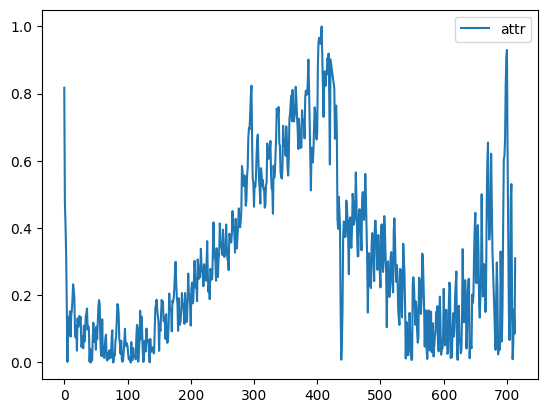

In [40]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

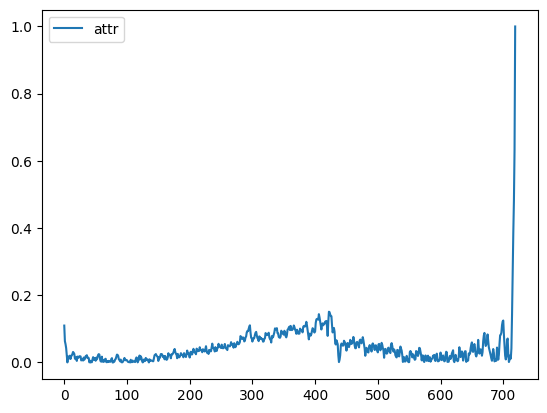

In [41]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [42]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [43]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


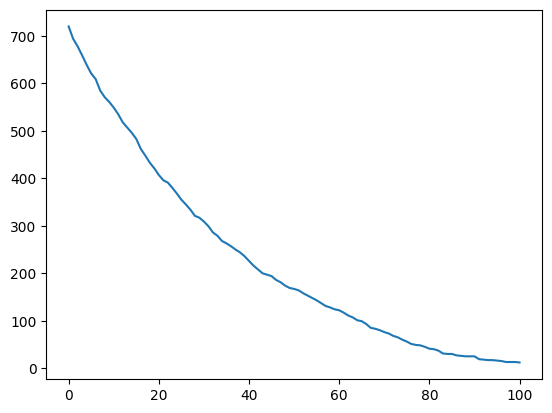

In [44]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [45]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:0.41064996954112576
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:0.412580

changed
changed
15번째 모델 Training 완료 마지막 Epoch loss:0.4173563801200082
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
16번째 모델 Training 완료 마지막 Epoch loss:0.4186314134643253
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
31번째 모델 Training 완료 마지막 Epoch loss:0.4421593329284333
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
32번째 모델 Training 완료 마지막 Epoch loss:0.44023197292201444
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
54번째 모델 Training 완료 마지막 Epoch loss:0.4875564104452527
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
55번째 모델 Training 완료 마지막 Epoch loss:0.4810447422648512
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
56번째 모델 Training 완료 마지막 Epoch loss:0.4901039562259785
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:0.4796572322081509
changed
changed
changed
changed
changed
changed


changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
83번째 모델 Training 완료 마지막 Epoch loss:0.4893677355249499
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
92번째 모델 Training 완료 마지막 Epoch loss:0.4941324415573528
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

In [46]:
val_y # 다음 예측 타겟값

tensor([[0.1677, 0.1679, 0.1648,  ..., 0.1821, 0.1825, 0.1705],
        [0.1679, 0.1648, 0.1547,  ..., 0.1825, 0.1705, 0.1887],
        [0.1648, 0.1547, 0.1461,  ..., 0.1705, 0.1887, 0.2247],
        ...,
        [0.1748, 0.1875, 0.1875,  ..., 0.1819, 0.1744, 0.1752],
        [0.1875, 0.1875, 0.1724,  ..., 0.1744, 0.1752, 0.1826],
        [0.1875, 0.1724, 0.1510,  ..., 0.1752, 0.1826, 0.2191]],
       device='cuda:0')

In [47]:
val_x # 예측 하는 값

tensor([[0.1676, 0.3280, 0.2684,  ..., 0.1539, 0.1544, 0.1493],
        [0.3280, 0.2684, 0.1458,  ..., 0.1544, 0.1493, 0.1677],
        [0.2684, 0.1458, 0.1177,  ..., 0.1493, 0.1677, 0.1679],
        ...,
        [0.1705, 0.1787, 0.1753,  ..., 0.1612, 0.1654, 0.1556],
        [0.1787, 0.1753, 0.1791,  ..., 0.1654, 0.1556, 0.1748],
        [0.1753, 0.1791, 0.1372,  ..., 0.1556, 0.1748, 0.1875]],
       device='cuda:0')

In [48]:
result/68

3.9528193370000845e-06

In [49]:
val_x.size()

torch.Size([33, 720])

        out
8  0.000177


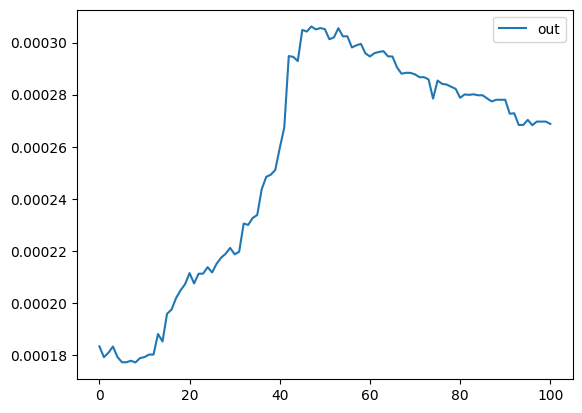

In [50]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [51]:
out_df 

,out
0,0.000183
1,0.000179
2,0.000181
3,0.000183
4,0.000179
...,...
96,0.000268
97,0.000270
98,0.000270
99,0.000270


        out
6  0.009405


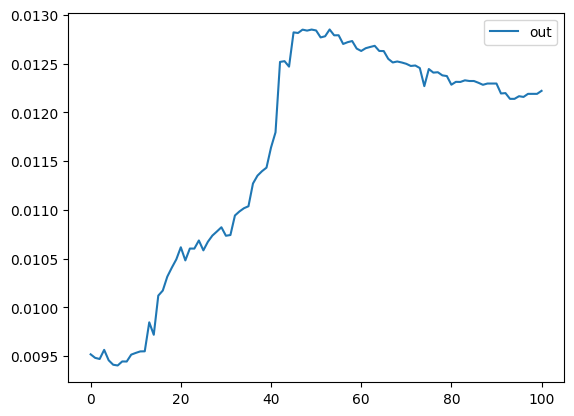

In [52]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [53]:
out_df 

,out
0,0.009519
1,0.009483
2,0.009472
3,0.009565
4,0.009458
...,...
96,0.012159
97,0.012190
98,0.012190
99,0.012190


        out
6  5.487391


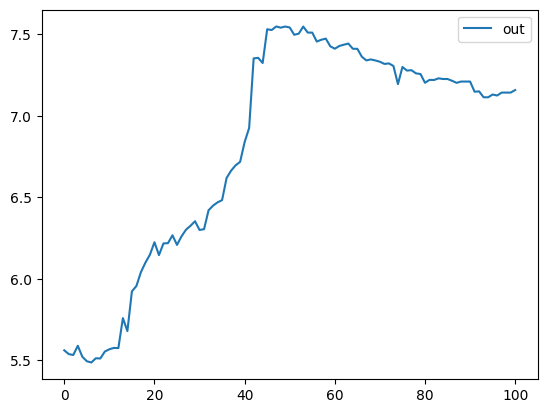

In [54]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [55]:
out_df 

,out
0,5.561928
1,5.538693
2,5.533352
3,5.589713
4,5.522926
...,...
96,7.124357
97,7.142298
98,7.142298
99,7.142298


        out
8  0.013314


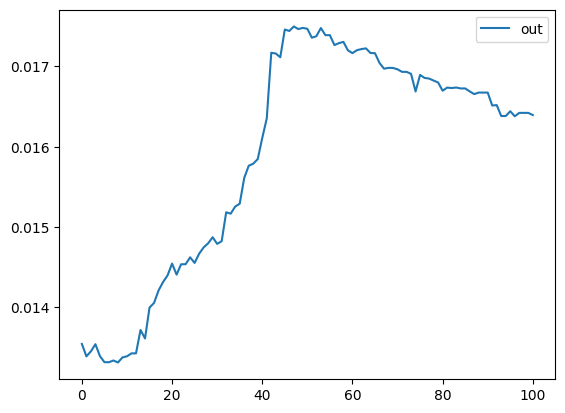

In [56]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [57]:
out_df 

,out
0,0.013545
1,0.013390
2,0.013452
3,0.013542
4,0.013393
...,...
96,0.016380
97,0.016422
98,0.016422
99,0.016422


In [58]:
attr_df.describe()

,attr
count,720.000000
mean,0.045182
std,0.058311
min,0.000000
25%,0.014326
50%,0.033073
75%,0.063266
max,1.000000
